In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Carregando os dados
data = pd.read_csv("./Data/Stocks/^BVSP.csv", usecols= ['Date','Open', 'High', 'Low', 'Close', 'Volume'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.describe()

import warnings
warnings.filterwarnings("ignore")

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2480 entries, 2010-01-04 to 2019-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2473 non-null   float64
 1   High    2473 non-null   float64
 2   Low     2473 non-null   float64
 3   Close   2473 non-null   float64
 4   Volume  2473 non-null   float64
dtypes: float64(5)
memory usage: 116.2 KB


In [68]:
#Removendo nulos
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2473 entries, 2010-01-04 to 2019-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2473 non-null   float64
 1   High    2473 non-null   float64
 2   Low     2473 non-null   float64
 3   Close   2473 non-null   float64
 4   Volume  2473 non-null   float64
dtypes: float64(5)
memory usage: 115.9 KB


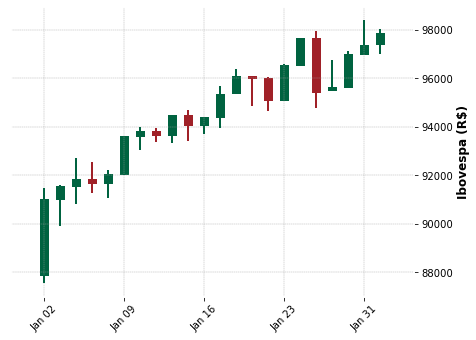

In [69]:
#Plotting...
import mplfinance as mpf
graph = data.copy()
mpf.plot(data[pd.to_datetime('01-01-2019'):pd.to_datetime('02-01-2019')], type='candle', figscale=1.0, volume=False, style='charles', ylabel='Ibovespa (R$)')

In [70]:
#Extracting Features
data['Close_Tomorrow'] = data['Close'].shift(-1)
data['Return'] = data['Close_Tomorrow'] - data['Close']
data

,Open,High,Low,Close,Volume,Close_Tomorrow,Return
Date,,,,,,,
2010-01-04,68587.0,70081.0,68587.0,70045.0,1655400.0,70240.0,195.0
2010-01-05,70046.0,70595.0,69928.0,70240.0,1984200.0,70729.0,489.0
2010-01-06,70237.0,70937.0,70016.0,70729.0,2243600.0,70451.0,-278.0
2010-01-07,70723.0,70723.0,70045.0,70451.0,1555000.0,70263.0,-188.0
2010-01-08,70455.0,70766.0,70158.0,70263.0,1634400.0,70433.0,170.0
...,...,...,...,...,...,...,...
2019-12-20,115133.0,115171.0,114526.0,115121.0,6887400.0,115863.0,742.0
2019-12-23,115119.0,115863.0,114964.0,115863.0,3995200.0,117203.0,1340.0
2019-12-26,115864.0,117220.0,115673.0,117203.0,3788900.0,116534.0,-669.0


In [71]:
#Normalizing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for c in data.columns:
    data[c+'_Norm'] = scaler.fit_transform(data[c].to_numpy().reshape(-1, 1))
data = data.dropna()

In [72]:
#Splitting the data
train = data[pd.to_datetime('01-01-2010'):pd.to_datetime('01-01-2015')]
train_x = data[['Open_Norm','High_Norm','Low_Norm','Close_Norm','Volume_Norm']].to_numpy()
train_y = data[['Return_Norm']].to_numpy()

val = data[pd.to_datetime('01-01-2015'):pd.to_datetime('01-01-2017')]
val_x = val[['Open_Norm','High_Norm','Low_Norm','Close_Norm','Volume_Norm']].to_numpy()
val_y = val[['Return_Norm']].to_numpy()

test = data[pd.to_datetime('01-01-2017'):pd.to_datetime('01-01-2020')]
test_x = test[['Open_Norm','High_Norm','Low_Norm','Close_Norm','Volume_Norm']]
test_y = test[['Return_Norm', 'Return']]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 30)                180       
_________________________________________________________________
dense_10 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_11 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 31        
Total params: 2,071
Trainable params: 2,071
Non-trainable params: 0
_________________________________________________________________


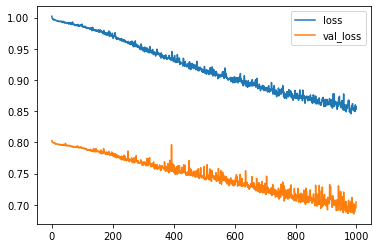

In [73]:
#Model
from keras import models
from keras import layers
from keras.layers import Dense
model = models.Sequential()
model.add(layers.Dense(30, input_dim = train_x.shape[1], activation = "relu"))
model.add(layers.Dense(30, activation ="relu"))
model.add(layers.Dense(30, activation ="relu"))
model.add(layers.Dense(1))  
model.summary()

model.compile(
optimizer = 'adam',
loss = 'mean_squared_error', #mean_squared_error
)
results = model.fit(
train_x, train_y,
epochs= 1000,
batch_size = 128,
validation_data = (val_x, val_y),
verbose = 0
)

plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

In [74]:
pred = model.predict(test_x)
pred = scaler.inverse_transform(pred)

test_y['Return_Predicted'] = pred
test_y['Movement_Predicted'] = [ 'Up' if p > 0 else 'Down' for p in pred]
test_y['Movement_Real'] = [ 'Up' if m > 0 else 'Down' for m in test_y['Return']]
test_y['Hit'] = [ 1 if m[1]['Movement_Real'] == m[1]['Movement_Predicted'] else 0 for m in test_y.iterrows()]
test_y['Investiment_Return'] = [m[1]['Return'] if m[1]['Movement_Predicted'] == 'Up' else 0 for m in test_y.iterrows()]
print('Return of Strategy:  R$',test_y['Investiment_Return'].sum(), ' Buy & Hold: R$',test_y['Return'].sum())
print('Investiment: R$\n',data[pd.to_datetime('01-01-2017'):].head(1)['Open'])


Return of Strategy:  R$ 125569.0  Buy & Hold: R$ 56375.0
Investiment: R$
 Date
2017-01-02    60227.0
Name: Open, dtype: float64


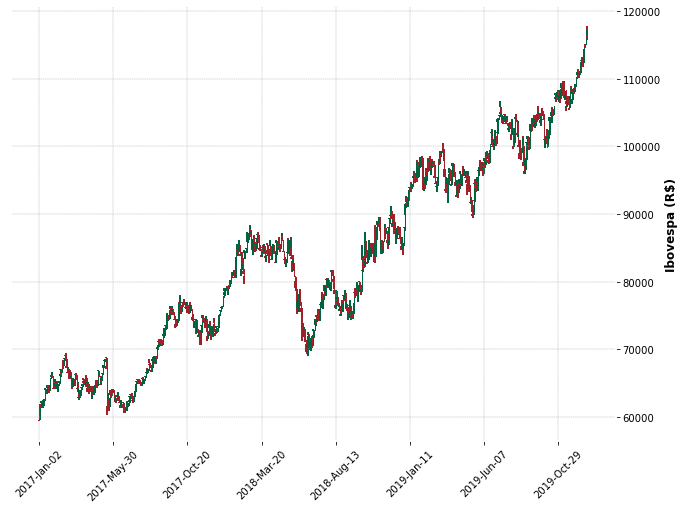

In [75]:
#Plotting...
import mplfinance as mpf
graph = data.copy()
mpf.plot(data[pd.to_datetime('01-01-2017'):pd.to_datetime('01-01-2020')], type='candle', figscale=1.5, volume=False, style='charles', ylabel='Ibovespa (R$)')